# TIME SERIES SPLIT

### LOAD LIBRARIES

In [1]:
import os
import gc
import warnings
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

### GLOBAL VARIABLES

In [2]:
INPUT_PATH = '../../data/features'
OUTPUT_PATH = '../../data/train_test'
INPUT_FILE_NAME = 'features_v001'
N_SPLITS = 3 # numbers of folds
DAY_COL = 'd'
DATE_COL = "date"
D_THRESH = 1941 - int(365 * 2) # he only left 2 years of training data, from 2014-05-23 to 2016-05-24
DAYS_PRED = 28

### FUNCTIONS

In [3]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            # step = (duration - total_sec) / (self.n_splits - 1)
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                # train_start = idx * step
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [4]:
def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)

In [5]:
def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [6]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

### LOAD DATASET

In [7]:
print("Reading files...")
data = pd.read_pickle(f'{INPUT_PATH}/{INPUT_FILE_NAME}.pkl')

Reading files...


### SPLIT DATASET

In [8]:
day_col = "d"
cv_params = {
    "n_splits": N_SPLITS,
    "train_days": int(365 * 1.5),
    "test_days": DAYS_PRED,
    "day_col": DAY_COL,
}

In [9]:
cv = CustomTimeSeriesSplitter(**cv_params)

### SHOW SPLIT DATASET

----- Fold: (1 / 3) -----


,start,end,days
train,2014-08-31,2016-02-28,547
test,2016-02-29,2016-03-27,28


----- Fold: (2 / 3) -----


,start,end,days
train,2014-09-28,2016-03-27,547
test,2016-03-28,2016-04-24,28


----- Fold: (3 / 3) -----


,start,end,days
train,2014-10-26,2016-04-24,547
test,2016-04-25,2016-05-22,28


30

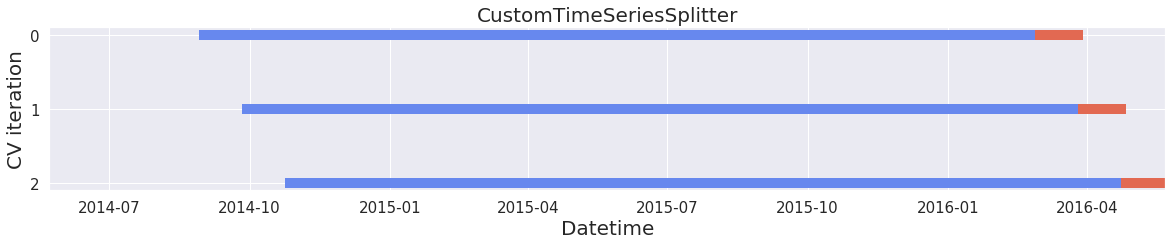

In [10]:
sample = data.iloc[::1000][[DAY_COL, DATE_COL]].reset_index(drop=True)
show_cv_days(cv, sample, DATE_COL, DAY_COL)
plot_cv_indices(cv, sample, DATE_COL)

del sample
gc.collect()

In [11]:
features = [c for c in data.columns if c not in [DAY_COL, 'id', 'part', DATE_COL]]

In [12]:
is_train = data["d"] < 1914

# Attach "d" to X_train for cross validation.
X_train = data[is_train][[DAY_COL] + features].reset_index(drop=True)
y_train = data[is_train]["demand"].reset_index(drop=True)
X_test = data[~is_train][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~is_train][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (21434470, 48)
X_test shape: (853720, 47)


In [14]:
X_trn_vector = [] # array where we will append all matrixs generated
X_val_vector = []
Y_trn_vector = []
Y_val_vector = []

for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X_train, y_train)):
    print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")
    print("processing datasets \n")
    X_trn, X_val = X_train[features].iloc[idx_trn].values, X_train[features].iloc[idx_val].values
    y_trn, y_val = y_train.iloc[idx_trn].values, y_train.iloc[idx_val].values
    print("loading dataset in vector \n")
    if idx_fold == 0:
        X_trn_vector = [X_trn]
        X_val_vector = [X_val]
        Y_trn_vector = [y_trn]
        Y_val_vector = [y_val]
    else:
        X_trn_vector.append(X_trn)
        X_val_vector.append(X_val)
        Y_trn_vector.append(y_trn)
        Y_val_vector.append(y_val)
    
    del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
    gc.collect()
    print("done \n")



----- Fold: (1 / 3) -----

processing datasets 

loading dataset in vector 

done 


----- Fold: (2 / 3) -----

processing datasets 

loading dataset in vector 

done 


----- Fold: (3 / 3) -----

processing datasets 

loading dataset in vector 

done 



In [17]:
X_trn_vector = np.array(X_trn_vector)
X_val_vector = np.array(X_val_vector)
Y_trn_vector = np.array(Y_trn_vector)
Y_val_vector = np.array(Y_val_vector)

### SAVE DATASET

In [18]:
np.save(f'{OUTPUT_PATH}/X_train.npy',X_trn_vector)
np.save(f'{OUTPUT_PATH}/X_val.npy',X_val_vector)
np.save(f'{OUTPUT_PATH}/Y_train.npy',Y_trn_vector)
np.save(f'{OUTPUT_PATH}/Y_val.npy',Y_val_vector)
np.save(f'{OUTPUT_PATH}/X_test.npy',X_test.values)